# Implementing Neural Network Training with Different Optimizers

### Objective:
The goal of this assignment is to implement a small neural network from scratch and train it using three different optimization algorithms: Stochastic Gradient Descent (SGD), SGD with Momentum, and SGD with AdaGrad. You will need to compare the performance of these optimizers.

## Grading comments

The most common type of error in this problem, by far, was mistakes in handling the softmax layer in the backward pass. Many students skipped it entirely, or calculated its derivative as a vector in some way. As a multivariate function, the derivative of the softmax function is a full matrix, and the proper way to apply the chain rule for backprop is to use matrix multiplication.

## Discussion questions

The main observations across the questions were:
- For the same algorithm, higher learning rate lead to faster convergence initially. However, depending on the dataset, a high learning rate will usually plateau at a higher loss, so in practice the learning rate is lowered over time. Additionally, if you tried unbatched mode without changing the learning rates, you will have learned that a learning rate that is too high fails to learn.
- SGD with momentum requires a lower learning rate to perform well as its step sizes are effectively multiplied by around 1/(1-α) .
- The same learning rate do not always work well across different models. AdaGrad performed better on the 3 layer network without changing the learning rate due to its adaptive step size.

## 1- Dataset

### Digits

This dataset, sourced from sklearn, consists of 1797 images, each sized 8x8 pixels. Every image, like the example shown below, depicts a handwritten digit. To utilize an 8x8 image, it must first be transformed into a feature vector of length 64.

The task with this dataset is to classify each digit, with a total of 10 classes.

The targets are one-hot encoded, i.e. each digit is transformed into a 10-dimensional vector with the element corresponding to the digit set to 1, and the other elements set to 0.

dataset's dimensions: (1797, 64)


<Figure size 640x480 with 0 Axes>

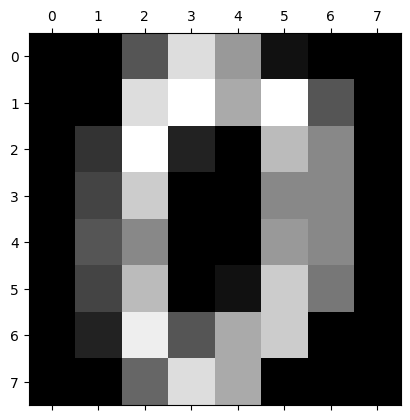

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

digits = load_digits()
print("dataset's dimensions:", digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()


In [ ]:
# this function loads train and test sets from digits dataset
def load_data():
    digits = load_digits()
    X = digits.data
    y = digits.target

    enc = OneHotEncoder()
    y = enc.fit_transform(y.reshape(-1, 1)).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, y_train, X_test, y_test

## 2- Neural Network Architecture:
* Implement a simple feedforward neural network with one hidden layer.
* Use sigmoid activation for the hidden layer and softmax for the output layer.
* Feel free to add any necessary functions to the class below.
* See figure 2 in assignment pdf for a diagram

In [ ]:
# Neural network forward and backward propagation
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

        self.dW1 = np.zeros((input_size, hidden_size))
        self.db1 = np.zeros((1, hidden_size))
        self.dW2 = np.zeros((hidden_size, output_size))
        self.db2 = np.zeros((1, output_size))

    def forward(self, X):
        # Implement forward pass
        # You should store the intermediate values as fields to be used by the backward pass
        # The forward pass must work for all batch sizes

        # X: the x values, batched along dimension zero
        # return: z2

        self.a1 = np.dot(X, self.W1) + self.b1
        self.z1 = sigmoid(self.a1)
        self.a2 = np.dot(self.z1, self.W2) + self.b2
        self.z2 = softmax(self.a2)
        return self.z2

    def backward(self, X, y):

        # Implement backward pass, assuming the MSE loss (see section 3 for clarification)
        # Use the intermediate values calculated from the forward pass,
        # and store the gradients in fields
        # The backward pass must also work for all batch sizes

        # X: the x values, batched along dimension zero
        # y: batched target values
        # return: None

        m = y.shape[0]

        # Output layer error
        dz2 = 2 * (self.z2 - y) / m
        # https://stackoverflow.com/questions/68422297/batch-matrix-multiplication-in-numpy/68425798#68425798
        da2 = np.einsum('Bi,BNi->BN', dz2, softmax_derivative(self.a2))
        self.dW2 = self.z1.T @ da2
        self.db2 = np.sum(da2, axis=0, keepdims=True)

        # Hidden layer error
        da1 = (da2 @ self.W2.T) * sigmoid_derivative(self.a1)
        self.dW1 = X.T @ da1
        self.db1 = np.sum(da1, axis=0, keepdims=True)

    def get_params_and_grads(self):
        # Return parameters and corresponding gradients
        params = [self.W1, self.b1, self.W2, self.b2]
        grads = [self.dW1, self.db1, self.dW2, self.db2]
        return params, grads


## 3- Helper Functions
Implement the following helper functions (the `plot_all_results` function is already implemented):

* `mean_squared_error(predictions, targets)`: This function receives the predicted values from the network and the target values, calculates the mean squared loss, and returns the loss value. For clarification, you should take the mean of the squared error over the samples in the batch, and *not* over the outputs of each sample

* `compute_accuracy(predictions, targets)`: This function receives the predicted values and the target values, and returns the accuracy of the predictions. The predicted value is the index with the highest network output (z2) value.

* Feel free to add any other necessary helper functions here.


In [ ]:
def mean_squared_error(predictions, targets):
    # Returns MSE loss
    mse = np.mean(np.sum((predictions - targets) ** 2, axis=1))
    return mse

def compute_accuracy(predictions, targets):
    # Returns the accuracy of the predicted labels (between 0 and 1)
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(targets, axis=1)
    return np.mean(pred_labels == true_labels)

def plot_all_results(all_losses, all_accuracies, all_labels):
    if len(all_losses) != len(all_accuracies):
      raise ValueError("all_losses length must be equal to all_accuracies length")

    if len(all_losses) != len(all_labels):
      raise ValueError("all_labels length must be equal to all_losses length")

    epochs = len(all_losses[0])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for i in range(len(all_losses)):
      plt.plot(range(1, epochs + 1), all_losses[i], label=all_labels[i])
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title(f'Training loss')

    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(len(all_losses)):
      plt.plot(range(1, epochs + 1), all_accuracies[i], label=all_labels[i])
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title(f'Training accuracy')

    plt.legend()
    plt.show()

# You may add helper functions here

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    # print(x.shape)
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_derivative(x):
    s = softmax(x)
    # https://stackoverflow.com/questions/53741481/vectorized-creation-of-an-array-of-diagonal-square-arrays-from-a-liner-array-in/53741833#53741833
    diag = np.identity(s.shape[1]) * np.expand_dims(s, 2)
    outer = np.expand_dims(s, 1) * np.expand_dims(s, 2)
    return diag - outer

## 4- Optimizer Implementations:
Implement the following optimization algorithms:

 * Stochastic Gradient Descent with minibatches (SGD)
 * SGD with Momentum
 * SGD with AdaGrad

Note that you must update each param in-place using `+=` or `-=` so that the weights of the network are updated.

In [ ]:
# Optimizer implementations (SGD, SGD with Momentum, AdaGrad)

class SGD():
    def __init__(self, params, learning_rate):
        self.params = params
        self.lr = learning_rate

    def step(self, grads):
        # Perform one step of SGD
        for i, grad in enumerate(grads):
            self.params[i] -= self.lr * grad

class SGD_Momentum():
    def __init__(self, params, learning_rate, alpha):
        self.params = params
        self.lr = learning_rate
        self.alpha = alpha

        # You may need to add other fields here
        self.vels = [np.zeros_like(p) for p in params]

    def step(self, grads):
        # Perform one step of SGD with momentum
        for i, g in enumerate(grads):
            self.vels[i] = self.vels[i] * self.alpha - self.lr * g
            self.params[i] += self.vels[i]

class SGD_AdaGrad():
    def __init__(self, params, learning_rate, delta):
        self.params = params
        self.lr = learning_rate
        self.delta = delta

        # You may need to add other fields here
        self.r = [np.zeros_like(p) for p in params]

    def step(self, grads):
        # Perform one step of SGD with adagrad
        for i, g in enumerate(grads):
            self.r[i] += g * g
            self.params[i] -= self.lr * g / (self.delta + self.r[i] ** 0.5)


## 5- Training Loop:

The `train` function is used to train your neural network. It returns the training loss and accuracy after each epoch.


In [ ]:
#batch generator
def gen_batches(data, labels, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size], labels[i:i+batch_size]

# Training loop
def train(network, data, optimizer, epochs, batch_size):
    X_train, y_train, X_test, y_test = data
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
      random_indices = np.random.permutation(list(range(X_train.shape[0])))
      X_train = X_train[random_indices]
      y_train = y_train[random_indices]
      for x, y in gen_batches(X_train, y_train, batch_size):
        # Forward pass
        output = network.forward(x)

        # Backward pass
        network.backward(x, y)

        # Get parameters and gradients
        params, grads = network.get_params_and_grads()

        # Update parameters using the chosen optimizer
        optimizer.step(grads)

      # Compute loss and accuracy
      X_test = X_train
      y_test = y_train
      output = network.forward(X_test)
      train_loss = mean_squared_error(output, y_test)
      train_accuracy = compute_accuracy(output, y_test)

      test_losses.append(train_loss)
      test_accuracies.append(train_accuracy)

      if epoch % 20 == 19:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    return test_losses, test_accuracies

## 6- Main function
Use the following main function to train your neural network based on sgd, sgd-momentum, and AdaGrad. The following hyperparameters are used in training:

* batch_size = 128
* input_size = 64
* hidden_size = 20
* output_size = 10
* learning_rate = see LR on graph legend
* For SGD with momentum, alpha = 0.9
* For SGD with AdaGrad, delta = 10^-8
* epochs = 200

Compare the performance of the 5 different training passes, and discuss the impact of the learning rate

Training with SGD LR 0.5
Epoch 20/200, Loss: 0.1611, Accuracy: 0.9325
Epoch 40/200, Loss: 0.0345, Accuracy: 0.9896
Epoch 60/200, Loss: 0.0214, Accuracy: 0.9937
Epoch 80/200, Loss: 0.0136, Accuracy: 0.9958
Epoch 100/200, Loss: 0.0114, Accuracy: 0.9958
Epoch 120/200, Loss: 0.0093, Accuracy: 0.9965
Epoch 140/200, Loss: 0.0075, Accuracy: 0.9986
Epoch 160/200, Loss: 0.0066, Accuracy: 0.9986
Epoch 180/200, Loss: 0.0060, Accuracy: 0.9986
Epoch 200/200, Loss: 0.0053, Accuracy: 0.9986
Training with SGD LR 0.2
Epoch 20/200, Loss: 0.4281, Accuracy: 0.6896
Epoch 40/200, Loss: 0.1118, Accuracy: 0.9756
Epoch 60/200, Loss: 0.0599, Accuracy: 0.9854
Epoch 80/200, Loss: 0.0359, Accuracy: 0.9896
Epoch 100/200, Loss: 0.0298, Accuracy: 0.9951
Epoch 120/200, Loss: 0.0216, Accuracy: 0.9958
Epoch 140/200, Loss: 0.0236, Accuracy: 0.9958
Epoch 160/200, Loss: 0.0158, Accuracy: 0.9972
Epoch 180/200, Loss: 0.0132, Accuracy: 0.9972
Epoch 200/200, Loss: 0.0138, Accuracy: 0.9972
Training with SGD with Momentum LR 0.0

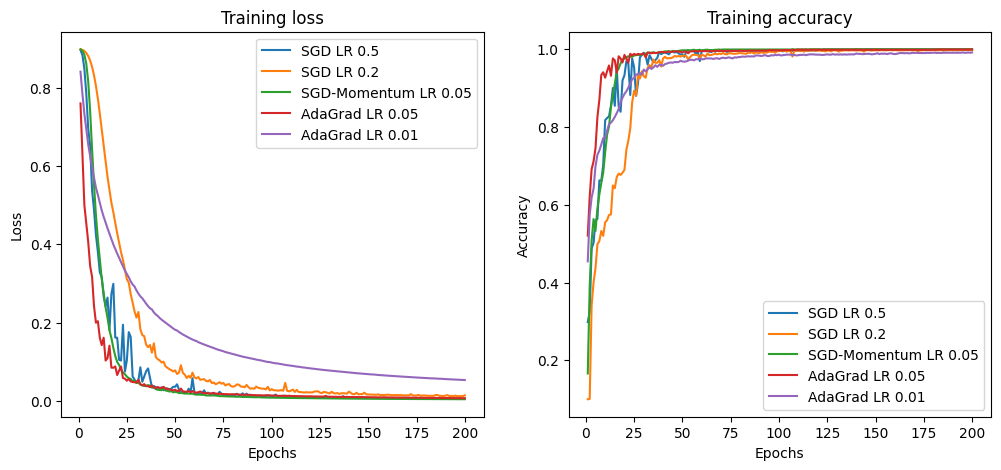

In [ ]:
# Main function to run the experiments
def main():
    data = load_data()
    batch_size = 128
    input_size = 64  # For the digits dataset (8x8 images flattened)
    hidden_size = 20
    output_size = 10
    epochs = 200

    print("Training with SGD LR 0.5")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_sgd, test_accuracies_sgd = train(network, data, SGD(network.get_params_and_grads()[0], 0.5), epochs, batch_size)

    print("Training with SGD LR 0.2")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_sgd_b, test_accuracies_sgd_b = train(network, data, SGD(network.get_params_and_grads()[0], 0.2), epochs, batch_size)

    print("Training with SGD with Momentum LR 0.05")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_momentum, test_accuracies_momentum = train(network, data, SGD_Momentum(network.get_params_and_grads()[0], 0.05, 0.9), epochs, batch_size)

    print("Training with AdaGrad LR 0.05")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_adagrad, test_accuracies_adagrad = train(network, data, SGD_AdaGrad(network.get_params_and_grads()[0], 0.05, 1e-8), epochs, batch_size)

    print("Training with AdaGrad LR 0.01")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_adagrad_b, test_accuracies_adagrad_b = train(network, data, SGD_AdaGrad(network.get_params_and_grads()[0], 0.01, 1e-8), epochs, batch_size)

    # Compare train losses and train accuracies
    all_losses = [test_losses_sgd, test_losses_sgd_b, test_losses_momentum, test_losses_adagrad, test_losses_adagrad_b]
    all_accuracies = [test_accuracies_sgd, test_accuracies_sgd_b, test_accuracies_momentum, test_accuracies_adagrad, test_accuracies_adagrad_b]
    all_labels = ["SGD LR 0.5", "SGD LR 0.2", "SGD-Momentum LR 0.05", "AdaGrad LR 0.05", "AdaGrad LR 0.01"]
    plot_all_results(all_losses, all_accuracies, all_labels)

if __name__ == "__main__":
    main()

## 7. Increasing Layers

Instead of using 2-layer neural networks. We can increase number of layers to three and observe the loss again based on sgd. The newly added layer should adopt the same hidden size.

We are sticking to the same hyper-parameters as before.

* Plot the loss and accuracy.

* Discuss the impact of the increased layers in the pdf

Training with SGD LR 0.5
Epoch 20/200, Loss: 0.9000, Accuracy: 0.1072
Epoch 40/200, Loss: 0.8999, Accuracy: 0.1072
Epoch 60/200, Loss: 0.8999, Accuracy: 0.1072
Epoch 80/200, Loss: 0.8995, Accuracy: 0.1072
Epoch 100/200, Loss: 0.8889, Accuracy: 0.2122
Epoch 120/200, Loss: 0.8070, Accuracy: 0.2283
Epoch 140/200, Loss: 0.7430, Accuracy: 0.2985
Epoch 160/200, Loss: 0.7011, Accuracy: 0.3862
Epoch 180/200, Loss: 0.5978, Accuracy: 0.4795
Epoch 200/200, Loss: 0.5309, Accuracy: 0.5804
Training with SGD LR 0.2
Epoch 20/200, Loss: 0.8999, Accuracy: 0.1072
Epoch 40/200, Loss: 0.8999, Accuracy: 0.1072
Epoch 60/200, Loss: 0.8999, Accuracy: 0.1072
Epoch 80/200, Loss: 0.8998, Accuracy: 0.1072
Epoch 100/200, Loss: 0.8998, Accuracy: 0.1072
Epoch 120/200, Loss: 0.8998, Accuracy: 0.1072
Epoch 140/200, Loss: 0.8998, Accuracy: 0.1072
Epoch 160/200, Loss: 0.8997, Accuracy: 0.1072
Epoch 180/200, Loss: 0.8996, Accuracy: 0.1072
Epoch 200/200, Loss: 0.8991, Accuracy: 0.2053
Training with SGD with Momentum LR 0.0

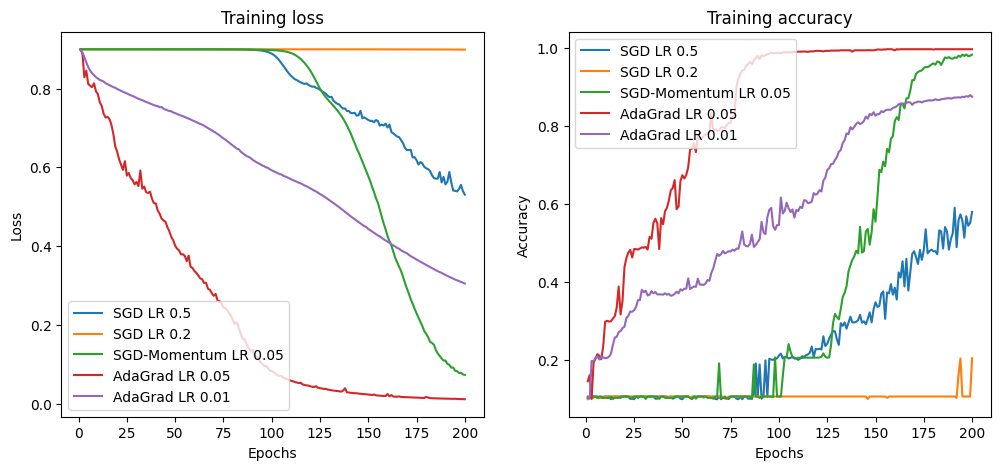

In [ ]:
# Please implement the 3-layer neural network and run the main function again to plot the curve.
# Neural network forward and backward propagation
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = np.random.randn(hidden_size, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))

        self.dW1 = np.zeros((input_size, hidden_size))
        self.db1 = np.zeros((1, hidden_size))
        self.dW2 = np.zeros((hidden_size, hidden_size))
        self.db2 = np.zeros((1, hidden_size))
        self.dW3 = np.zeros((hidden_size, output_size))
        self.db3 = np.zeros((1, output_size))

    def forward(self, X):
        # Implement forward pass
        # You should store the intermediate values as fields to be used by the backward pass
        # The forward pass must work for all batch sizes

        # X: the x values, batched along dimension zero
        # return: z2

        self.a1 = np.dot(X, self.W1) + self.b1
        self.z1 = sigmoid(self.a1)
        self.a2 = np.dot(self.z1, self.W2) + self.b2
        self.z2 = sigmoid(self.a2)
        self.a3 = np.dot(self.z2, self.W3) + self.b3
        self.z3 = softmax(self.a3)
        return self.z3

    def backward(self, X, y):

        # Implement backward pass, assuming the MSE loss (see section 3 for clarification)
        # Use the intermediate values calculated from the forward pass,
        # and store the gradients in fields
        # The backward pass must also work for all batch sizes

        # X: the x values, batched along dimension zero
        # y: batched target values
        # return: None

        m = y.shape[0]

        # Output layer error
        dz3 = 2 * (self.z3 - y) / m
        # https://stackoverflow.com/questions/68422297/batch-matrix-multiplication-in-numpy/68425798#68425798
        da3 = np.einsum('Bi,BNi->BN', dz3, softmax_derivative(self.a3))
        self.dW3 = self.z2.T @ da3
        self.db3 = np.sum(da3, axis=0, keepdims=True)

        # Hidden layer error
        da2 = (da3 @ self.W3.T) * sigmoid_derivative(self.a2)
        self.dW2 = self.z1.T @ da2
        self.db2 = np.sum(da2, axis=0, keepdims=True)

        da1 = (da2 @ self.W2.T) * sigmoid_derivative(self.a1)
        self.dW1 = X.T @ da1
        self.db1 = np.sum(da1, axis=0, keepdims=True)

    def get_params_and_grads(self):
        # Return parameters and corresponding gradients
        params = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        grads = [self.dW1, self.db1, self.dW2, self.db2, self.dW3, self.db3]
        return params, grads


main()